In [2]:
import pip

def import_or_install(package):
    try:
        __import__(package)
    except ImportError:
        pip.main(['install', package])       

import_or_install('tensorflow')
import_or_install('pydot')


2023-11-20 14:50:18.034394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
import pyarrow as pa
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from source import data_import

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [6]:
import tensorflow as tf

import keras 
from keras.models import Sequential # intitialize the ANN
from keras.layers import Dense, Activation, Dropout 

In [7]:
import source.plots as plots

In [8]:
RSEED = 42
np.random.seed(seed=RSEED)
tf.random.set_seed(RSEED)

In [186]:
try:
    data
    print('data already loaded in parent notebook')
except NameError:
    data = np.load('data/extracted_features.npy')
data.shape

data already loaded in parent notebook


(13330, 30, 63)

In [9]:
data = np.load('data/psd_wav_features.npy')


In [10]:
import numpy as np

def split_data(data, train_size=0.8, random_state=None):
    np.random.seed(seed=RSEED)

    # Assuming the first column contains the IDs
    ids_column = data[:, 0, 0]

    # Find unique epoch IDs
    unique_epoch_ids = np.unique(ids_column)

    # Shuffle the unique epoch IDs
    np.random.shuffle(unique_epoch_ids)

    # Calculate the number of unique epoch IDs for training, validation, and testing
    train_samples_nr = int(np.floor(train_size * len(unique_epoch_ids)))
    print(f'{train_samples_nr} of epochs for training, {len(unique_epoch_ids) - train_samples_nr} of epochs for testing/validation')

    # Split the unique epoch IDs into train, validation, and test sets

    train_sample_ids = unique_epoch_ids[:train_samples_nr]
    test_sample_ids = unique_epoch_ids[train_samples_nr:]

    # Create boolean masks for filtering
    train_mask = np.in1d(ids_column, train_sample_ids)
    test_mask = np.in1d(ids_column, test_sample_ids)

    # Apply the masks to create train, validation, and test samples
    train_sample = data[train_mask, :, :]
    test_sample = data[test_mask, :, :]

    X_train = train_sample[:,:,:-1]
    X_test = test_sample[:,:,:-1]

    Y_train = train_sample[:,:,-1]
    Y_test = test_sample[:,:,-1]

    y_test=Y_test.max(axis=1)
    y_train=Y_train.max(axis=1)

    return X_train, X_test, Y_train, Y_test, y_train, y_test


In [11]:
X_train, X_test, Y_train, Y_test, y_train, y_test = split_data(data)
print(f'train shape', X_train.shape, f'ratio of seizures {y_train.sum()/len(y_train):.2f}')
print(f'test shape {X_test.shape}, ratio of seizures {y_test.sum()/len(y_test):.2f}')

344 of epochs for training, 86 of epochs for testing/validation
train shape (10664, 30, 92) ratio of seizures 0.14
test shape (2666, 30, 92), ratio of seizures 0.13


In [12]:
# Scaling features
num_features_train = X_train[:,:,2:]
num_features_test = X_test[:,:,2:]

# Get the dimensions of the original array
num_epochs_tr, num_segments_per_epoch_tr, features_tr = num_features_train.shape
num_epochs_te, num_segments_per_epoch_te, features_te = num_features_test.shape

# Reshape the array to 2D
reshaped_array_train = num_features_train.reshape(num_epochs_tr * num_segments_per_epoch_tr, features_tr)
reshaped_array_test = num_features_test.reshape(num_epochs_te * num_segments_per_epoch_te, features_te)

# Scaling features
scaler = StandardScaler()
num_features_scaled_tr = scaler.fit_transform(reshaped_array_train)
num_features_scaled_te = scaler.transform(reshaped_array_test)

X_train_scaled = num_features_scaled_tr.reshape(num_epochs_tr, num_segments_per_epoch_tr, features_tr)
X_test_scaled = num_features_scaled_te.reshape(num_epochs_te, num_segments_per_epoch_te, features_te)

print(f'train shape', X_train_scaled.shape)
print(f'test shape', X_test_scaled.shape)

train shape (10664, 30, 90)
test shape (2666, 30, 90)


In [13]:
X_train = X_train_scaled
X_test = X_test_scaled

In [14]:
import numpy as np
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

class_labels, class_counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)
class_weights = total_samples / (len(class_labels) * class_counts)

# Convert class weights to a dictionary
class_weight_dict = dict(zip(class_labels, class_weights))


In [15]:
class_labels, class_counts = np.unique(y_train, return_counts=True)

In [16]:
class_weight_dict

{0.0: 0.5830508474576271, 1.0: 3.510204081632653}

In [17]:
N_TRAIN = len(X_train)
EPOCHS = 400
BATCH_SIZE = 100
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [18]:
STEPS_PER_EPOCH

106

In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from keras import regularizers

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

#model.add(normalizer)

# Recurrent layer
model.add(LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(0.01)))

model.add(Dropout(0.5))  # Add dropout after LSTM

# Fully connected layer
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Dropout for regularization
model.add(Dropout(0.5))

model.add(BatchNormalization())

# Calculate the imbalance ratio
pos_ratio = class_weight_dict[1] / (class_weight_dict[0] + class_weight_dict[1])

# Calculate the initial bias based on the imbalance ratio
initial_bias = -np.log(pos_ratio)

# Output layer with a custom bias for initial probability
model.add(Dense(1, activation='sigmoid', bias_initializer=tf.keras.initializers.Constant(initial_bias)))

# Compile the model
#learning_rate = 0.001  # Replace with your desired learning rate

# Create an instance of the Adam optimizer with the specified learning rate

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.00001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=0.001,
    staircase=False)


optimizer = Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'AUC'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               112128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [21]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

# Create ModelCheckpoint callback to save the best model
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Combine the callbacks in a list
callbacks = [early_stopping, model_checkpoint]

In [22]:
y_train.shape

(10664,)

In [23]:
## look at validation batch ?
history = model.fit(X_train,  y_train, 
                    batch_size=BATCH_SIZE, 
                    class_weight=class_weight_dict,
                    shuffle=True,
                    epochs=EPOCHS,
                    validation_data= (X_test, y_test),
                    callbacks=callbacks
                    )

Epoch 1/400
107/107 [==============================] - 10s 56ms/step - loss: 3.7220 - accuracy: 0.4616 - auc: 0.4868 - val_loss: 3.5526 - val_accuracy: 0.2423 - val_auc: 0.4780
Epoch 2/400
  3/107 [..............................] - ETA: 4s - loss: 3.7565 - accuracy: 0.4833 - auc: 0.4855

/Users/anabroggini/Documents/bootcamp/ai2/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 5s 49ms/step - loss: 3.6736 - accuracy: 0.4711 - auc: 0.5056 - val_loss: 3.5304 - val_accuracy: 0.2986 - val_auc: 0.5521
Epoch 3/400
107/107 [==============================] - 5s 50ms/step - loss: 3.6367 - accuracy: 0.4772 - auc: 0.5190 - val_loss: 3.5091 - val_accuracy: 0.3957 - val_auc: 0.5998
Epoch 4/400
107/107 [==============================] - 5s 50ms/step - loss: 3.5846 - accuracy: 0.4889 - auc: 0.5339 - val_loss: 3.4859 - val_accuracy: 0.4895 - val_auc: 0.6415
Epoch 5/400
107/107 [==============================] - 6s 54ms/step - loss: 3.5696 - accuracy: 0.4894 - auc: 0.5373 - val_loss: 3.4595 - val_accuracy: 0.5401 - val_auc: 0.6744
Epoch 6/400
107/107 [==============================] - 7s 67ms/step - loss: 3.5195 - accuracy: 0.4985 - auc: 0.5582 - val_loss: 3.4307 - val_accuracy: 0.5709 - val_auc: 0.6921
Epoch 7/400
107/107 [==============================] - 9s 85ms/step - loss: 3.5122 - accuracy: 0.4948 - auc: 0.5455 - val_loss: 3.40

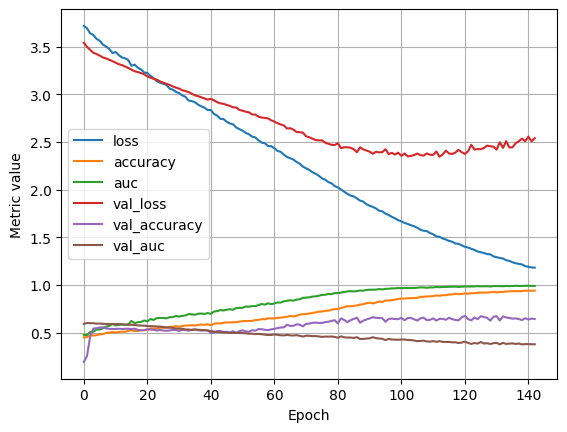

In [223]:
plots.plot_history_metrics(history)

In [156]:
metrics = model.evaluate(X_test, y_test, verbose=2)
print(f'Model accuracy: {metrics}')

84/84 - 0s - loss: 1.4784 - accuracy: 0.7202 - auc: 0.6499 - 375ms/epoch - 4ms/step
Model accuracy: [1.4784001111984253, 0.7201800346374512, 0.6498697996139526]


In [59]:
y_pred_train = model.predict(X_train)

334/334 [==============================] - 3s 7ms/step


In [224]:
y_pred = model.predict(X_test)
y_pred_c = y_pred.round().astype(int)
y_pred_c.shape

84/84 [==============================] - 3s 11ms/step


(2666, 1)

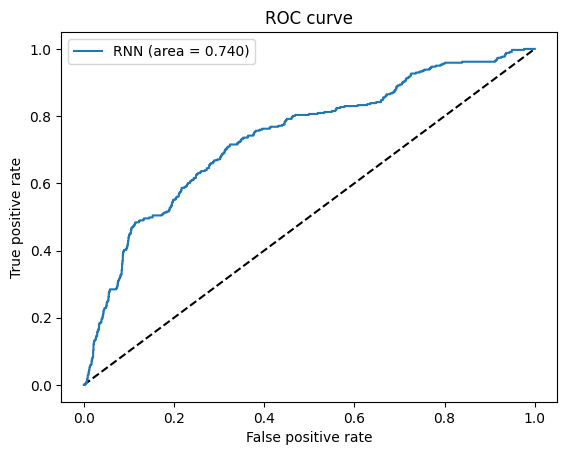

In [225]:
plots.plot_roc(y_test, y_pred)

In [204]:
metrics

[1.1895338296890259, 0.6995499134063721, 0.6688827872276306]

In [226]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix
y_pred_c = y_pred.round().astype(int)
precision = precision_score(y_test, y_pred_c)
recall = recall_score(y_test, y_pred_c)

metrics = model.evaluate(X_test, y_test)

print('Loss:', metrics[0])
print('Accuracy:', metrics[1])
print('AUC:', metrics[2])
print('Precision:', precision)
print('Recall:', recall)
y_test.sum(), y_pred_c.sum()


84/84 [==============================] - 1s 13ms/step - loss: 1.9582 - accuracy: 0.7749 - auc: 0.7399
Loss: 1.9581693410873413
Accuracy: 0.7749437093734741
AUC: 0.7399287819862366
Precision: 0.28805237315875615
Recall: 0.5161290322580645


(341.0, 611)

In [137]:
# Print the results
print("Metrics: ", model.metrics_names)
print("Results: ", metrics)

Metrics:  ['loss', 'accuracy', 'auc']
Results:  [1.385009527206421, 0.7786946892738342, 0.6934046149253845]


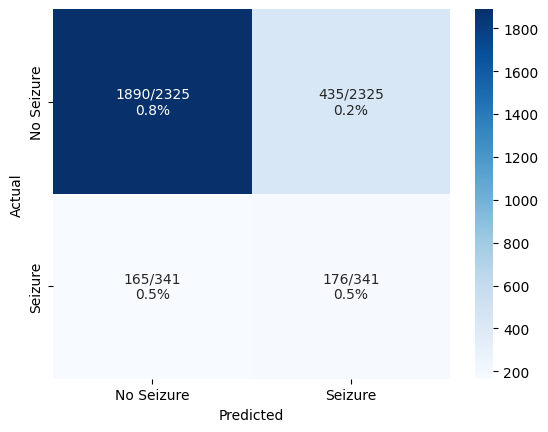

In [227]:
plots.plot_confusion_matrix(y_test, y_pred_c)

In [139]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred_c)
print("Classification Report:")
print(report)
 

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.83      0.87      2325
         1.0       0.27      0.43      0.33       341

    accuracy                           0.78      2666
   macro avg       0.59      0.63      0.60      2666
weighted avg       0.83      0.78      0.80      2666



In [172]:
model_checkpoint.best

1.5736794471740723

In [141]:
!mkdir -p saved_model

model.save('saved_model/my_RNN_model_60per5_fixing_overfit2')

INFO:tensorflow:Assets written to: saved_model/my_RNN_model_60per5_fixing_overfit2/assets


INFO:tensorflow:Assets written to: saved_model/my_RNN_model_60per5_fixing_overfit2/assets


In [48]:
# # Define a sequential model
# model = keras.Sequential()

# #model.add(normalizer)

# # Add an input layer with an input shape of (time_steps, input_features)
# model.add(layers.InputLayer(input_shape=(X_train.shape[1],X_train.shape[2])))

# # Add a SimpleRNN layer with 32 units (neurons)
# model.add(layers.SimpleRNN(72, activation='tanh'))

# model.add(BatchNormalization())

# # Add the output layer with 1 neuron and sigmoid activation for binary classification
# model.add(layers.Dense(1, activation='sigmoid'))

# # Compile the model with binary cross-entropy loss for binary classification
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [47]:
# history = model.fit(X_train,  y_train, 
#                     batch_size=100, 
#                     class_weight=class_weight_dict,
#                     shuffle=True,
#                     epochs=300,
#                     validation_data=(X_val, y_val))

In [173]:
# plot_loss(history)

In [174]:
# y_pred = model.predict(X_test).flatten()
# y_pred

In [ ]:
# loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
# print(f'Model accuracy: {accuracy}')

16/16 - 0s - loss: 0.6718 - accuracy: 0.5746 - 234ms/epoch - 15ms/step
Model accuracy: 0.5745967626571655


In [175]:
# from sklearn.metrics import precision_score, recall_score
# y_pred_c = y_pred.round().astype(int)
# precision = precision_score(y_test, y_pred_c)
# recall = recall_score(y_test, y_pred_c)

# loss, accuracy = model.evaluate(X_test, y_test)

# print('Loss:', loss)
# print('Accuracy:', accuracy)
# print('Precision:', precision)
# print('Recall:', recall)
# y_test.sum(), y_pred_c.sum()